In [1]:
import pandas as pd
from datasets import Dataset, DatasetDict
from utils import import_dataset

In [2]:
dataset = import_dataset()

In [3]:
dataset

DatasetDict({
    train: Dataset({
        features: ['title', 'genre', 'text', 'labels'],
        num_rows: 2476
    })
    eval: Dataset({
        features: ['title', 'genre', 'text', 'labels'],
        num_rows: 309
    })
    test: Dataset({
        features: ['title', 'genre', 'text', 'labels'],
        num_rows: 310
    })
})

https://huggingface.co/docs/transformers/tasks/sequence_classification

In [4]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
from transformers import AutoTokenizer
from transformers import DataCollatorWithPadding
import evaluate
accuracy = evaluate.load("accuracy")
import numpy as np
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

/home/antonauna/miniconda3/envs/torch/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/antonauna/miniconda3/envs/torch/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [5]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [6]:
id2label = {0: "dialogues", 
            1: "dissertation",
            2: "enquiry",
            3: "essay",
            4: "history",
            5: "political discourses",
            6: "treatise"}

label2id = {"dialogues": 0, 
            "dissertation": 1,
            "enquiry": 2,
            "essay": 3,
            "history": 4,
            "political discourses": 5,
            "treatise": 6}

In [11]:
def run_model(model_name, n_epochs, print_examples=False):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
    
    def preprocess_function(examples):
        return tokenizer(examples["text"], truncation=True, max_length=512)
    
    tokenized_dataset = dataset.map(preprocess_function, batched=True)
    
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name, 
        num_labels=7, 
        id2label=id2label, 
        label2id=label2id)
    
    training_args = TrainingArguments(
        output_dir=f"models/{model_name}-finetuned",
        learning_rate=2e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=n_epochs,
        weight_decay=0.01,
        logging_strategy="epoch",
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True)

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_dataset["train"],
        eval_dataset=tokenized_dataset["eval"],
        processing_class=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
    )

    trainer.train()
    
    ## testing
    
    correct = 0
    samples = 0

    y_test = []
    predictions = []


    for line in tokenized_dataset['test']:
        text = line['text']
        label = line['labels']
        inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512).to(device)
        with torch.no_grad():
            logits = model(**inputs).logits
        predicted_class_id = logits.argmax().item()
    #     model.config.id2label[predicted_class_id]
        if label == predicted_class_id:
            correct += 1
        samples += 1

        y_test.append(label)
        predictions.append(predicted_class_id)

        if print_examples and label == 4 and predicted_class_id != 4:
            print(f'history predicted as {id2label[predicted_class_id]}')
            print(line['title'])
            print(text)
            print()
            
    print('TEST ACCURACY: ', correct/samples)
    
    classes = ['dialogues', 'dissertation', 'enquiry', 'essay', 'history', 'political discourses', 'treatise']

    fig, ax = plt.subplots(figsize=(10, 5))
    ConfusionMatrixDisplay.from_predictions(y_test, predictions, ax=ax)
    ax.xaxis.set_ticks([0, 1, 2, 3, 4, 5, 6], classes, rotation=60)
    ax.yaxis.set_ticks([0, 1, 2, 3, 4, 5, 6], classes)
    plt.title(model_name)

Map:   0%|          | 0/2476 [00:00<?, ? examples/s]

Map:   0%|          | 0/309 [00:00<?, ? examples/s]

Map:   0%|          | 0/310 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,1.419600,1.061003,0.588997
2,0.873300,0.850368,0.686084
3,0.581400,0.729523,0.741100
4,0.385100,0.752900,0.754045
5,0.247800,0.717855,0.763754
6,0.142200,0.776578,0.779935
7,0.084200,0.824074,0.783172
8,0.051000,0.916134,0.779935
9,0.035300,0.905782,0.776699
10,0.027800,0.898503,0.779935


history predicted as essay
APPENDIX III
One of the most ancient and most established instruments of power was the court of Star-chamber, which possessed an unlimited discretionary authority of fining, imprisoning, and inflicting corporal punishment, and whose jurisdiction extended to all sorts of offences, contempts, and disorders, that lay not within reach of the common law. The members of this court consisted of the privy council and the judges; men, who all of them enjoyed their offices during pleasure: And when the prince himself was present, he was the sole judge, and all the others could only interpose with their advice. There needed but this one court in any government, to put an end to all regular, legal, and exact plans of liberty. For who durst set himself in opposition to the crown and ministry, or aspire to the character of being a patron of freedom, while exposed to so arbitrary a jurisdiction? I much question, whether any of the absolute monarchies in Europe contain, at p

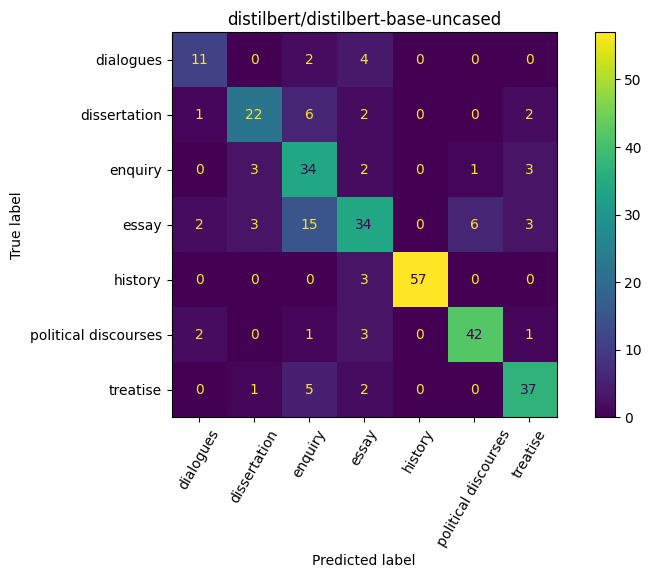

In [13]:
run_model('distilbert/distilbert-base-uncased', n_epochs=10, print_examples=True)

Map:   0%|          | 0/2476 [00:00<?, ? examples/s]

Map:   0%|          | 0/309 [00:00<?, ? examples/s]

Map:   0%|          | 0/310 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at TurkuNLP/eccobert-base-cased-v1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,1.260400,0.836675,0.676375
2,0.622800,0.613863,0.766990
3,0.326700,0.533759,0.818770
4,0.180800,0.643711,0.809061
5,0.084900,0.674585,0.838188
6,0.035200,0.706804,0.838188
7,0.014100,0.744526,0.828479
8,0.007100,0.744845,0.844660
9,0.004300,0.743336,0.844660
10,0.004100,0.742647,0.854369


TEST ACCURACY:  0.8193548387096774


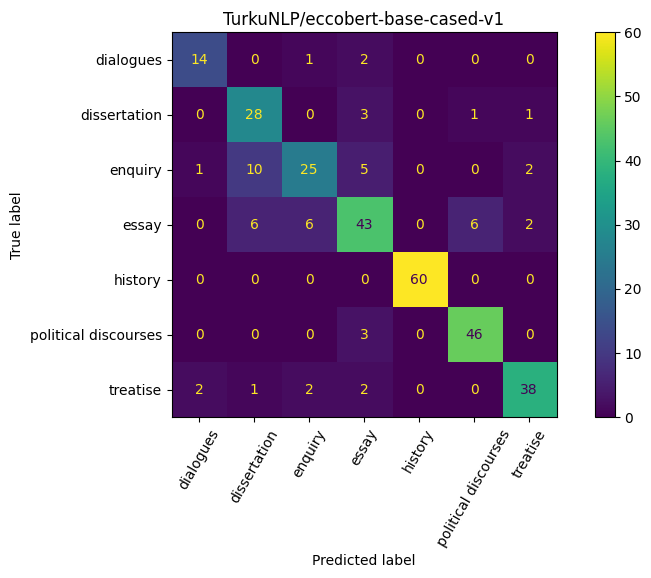

In [12]:
run_model('TurkuNLP/eccobert-base-cased-v1', n_epochs=10)

Map:   0%|          | 0/2476 [00:00<?, ? examples/s]

Map:   0%|          | 0/309 [00:00<?, ? examples/s]

Map:   0%|          | 0/310 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,1.461900,1.028903,0.618123
2,0.958300,0.777764,0.686084
3,0.648000,0.779121,0.718447
4,0.448700,0.719250,0.757282
5,0.294300,0.676907,0.799353
6,0.178300,0.649345,0.815534
7,0.117900,0.699722,0.838188
8,0.072800,0.789972,0.809061
9,0.043300,0.789393,0.831715
10,0.023100,0.817893,0.828479


TEST ACCURACY:  0.8032258064516129


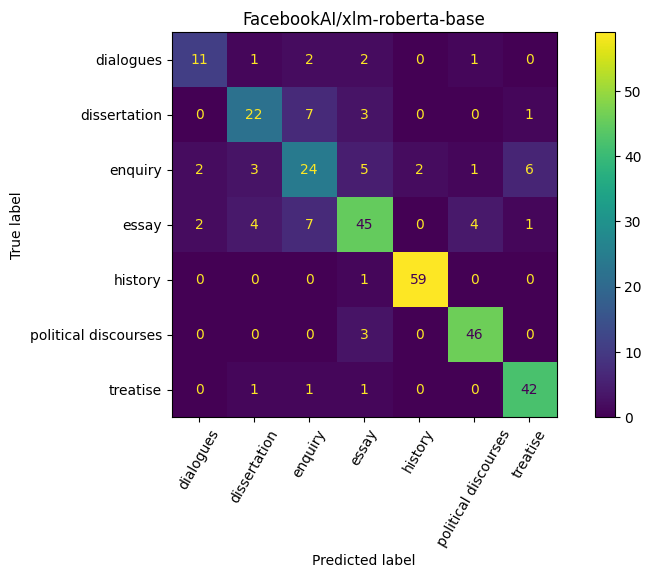

In [14]:
run_model('FacebookAI/xlm-roberta-base', n_epochs=10)